In [1]:
%load_ext autoreload
%autoreload 2

import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import pandas as pd
import numpy as np
from sklearn.preprocessing import MaxAbsScaler
import warnings
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
import pickle
import datetime
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from mlopt.ACO import ACO
from mlopt.AGMLP_Residual import AGMLP_Residual
from mlopt.AGMLP_VR_Residual import AGMLP_VR_Residual
from mlopt.AGEnsemble_Residual import AGEnsemble_Residual
from mlopt.TimeSeriesUtils import *
from correctData import *
import copy

warnings.filterwarnings("ignore")

# Load and Process Data

In [5]:
inmet_csv = './historical_data_maceio.csv'
save_scaler = "resultados/MaxAbsScaler_gen.pckl"

df_inmet = pd.read_csv(inmet_csv, sep=',', encoding = "ISO-8859-1")

for c in df_inmet.columns:
    if (c not in ['data', 'hora']) and (df_inmet[c].dtype != "float64"):
        print(df_inmet[c].dtype)
        df_inmet[c] = df_inmet[c].apply(lambda x: float(str(x).replace(",","."))).fillna(method='ffill')
    
print(df_inmet.dtypes)

ultimos_dias = 30*24

posicao_final=len(df_inmet)-1
posicao_inicial=posicao_final - ultimos_dias

exog = df_inmet[['preciptacao_total_mm', 'temp_ar_bulbo_seco_c', 'umidade_relativa_prcnt',
                 'vento_velocidade_mps', 'vento_rajada_max_mps']].iloc[posicao_inicial:,:]

gen = df_inmet['radiacao_global_wpm2'].iloc[posicao_inicial:].values.reshape(-1,1)

print("data hora inicial: ", df_inmet.iloc[posicao_inicial,:].data, df_inmet.iloc[posicao_inicial,:].hora,
      "data hora final: ", df_inmet.iloc[posicao_final,:].data,df_inmet.iloc[posicao_final,:].hora)

MaxAbsScaler_exog = MaxAbsScaler().fit(exog)
MaxAbsScaler_gen = MaxAbsScaler().fit(gen)

exog = MaxAbsScaler_exog.transform(exog)
gen = MaxAbsScaler_gen.transform(gen)[:,0]
#pickle.dump(MaxAbsScaler_gen, open(save_scaler, 'wb'))

object
object
object
object
object
object
object
object
object
object
object
object
object
int64
int64
int64
data                           object
hora                            int64
preciptacao_total_mm          float64
pressao_atm_mB                float64
pressao_atm_max_mB            float64
pressao_atm_min_mB            float64
radiacao_global_wpm2          float64
temp_ar_bulbo_seco_c          float64
temp_ponto_orvalho_c          float64
temp_max_c                    float64
temp_min_c                    float64
temp_orvalho_max_c            float64
temp_orvalor_min_c            float64
umidade_relativa_max_prcnt    float64
umidade_relativa_min_prcnt    float64
umidade_relativa_prcnt        float64
vento_dir_gr                  float64
vento_rajada_max_mps          float64
vento_velocidade_mps          float64
ano                           float64
mes                           float64
dia                           float64
dtype: object
data hora inicial:  2020-03-12 20 data ho

# SARIMAX 

## Auto ARIMA

In [8]:
pm.auto_arima(y=gen, X=exog, seasonal=True, m=24, maxiter=50, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=-1557.787, Time=10.24 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=-717.270, Time=0.79 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=-1454.105, Time=6.70 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=-1225.230, Time=6.65 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-711.355, Time=0.25 sec
 ARIMA(2,0,2)(0,0,1)[24] intercept   : AIC=-1448.678, Time=10.88 sec
 ARIMA(2,0,2)(1,0,0)[24] intercept   : AIC=-1467.922, Time=8.85 sec
 ARIMA(2,0,2)(2,0,1)[24] intercept   : AIC=-1559.195, Time=41.63 sec
 ARIMA(2,0,2)(2,0,0)[24] intercept   : AIC=-1504.052, Time=37.23 sec
 ARIMA(2,0,2)(2,0,2)[24] intercept   : AIC=inf, Time=46.47 sec
 ARIMA(2,0,2)(1,0,2)[24] intercept   : AIC=-1556.371, Time=42.65 sec
 ARIMA(1,0,2)(2,0,1)[24] intercept   : AIC=-1576.824, Time=35.69 sec
 ARIMA(1,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=9.94 sec
 ARIMA(1,0,2)(2,0,0)[24] intercept   : AIC=-1499.356, Time=36.26 sec
 ARIMA(1,0,

ARIMA(order=(1, 0, 2), scoring_args={}, seasonal_order=(1, 0, 2, 24),
      suppress_warnings=True)

In [9]:
mod = SARIMAX(endog=gen, exog=exog, order=(1,0,2), seasonal_order=(1,0,2, 24),
              enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit(disp=True)
y_sarimax_auto = results.predict()
mape_autoarima = MAPE(y_sarimax_auto, gen)
print("AICc: {0}, Mape: {1}".format(results.aicc, mape_autoarima))

AICc: -1488.858732966085, Mape: 5.3497697460376346


## PSO-ACO Parametrization

In [4]:
p = [0, 1, 2]
d = [0, 1]
q = [0, 1, 2, 3]
sp = [0, 1, 2]
sd = [0, 1]
sq = [0, 1, 2, 3]
s = [24, 48] #como são dados horarios...
# search Space, exog possibilities comes in the functions.
searchSpace = [p, d, q, sp, sd, sq, s]

options_PSO = {'n_particles':5,'n_iterations':3,'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 3, 'p': 2}
options_ACO = {'antNumber':3, 'antTours':3, 'alpha':2, 'beta':2, 'rho':0.5, 'Q':2}
y_sarimax_PSO_ACO = sarimax_PSO_ACO_search(endo_var=gen, exog_var_matrix=exog, searchSpace=copy.copy(searchSpace), 
                                   options_PSO=options_PSO, options_ACO=options_ACO, verbose=False)
mape_pso_aco = MAPE(y_sarimax_PSO_ACO, gen)
print("Mape: {0}".format(mape_pso_aco))

2021-01-31 22:30:15,939 - root - INFO - Original search Space: [[0, 1, 2], [0, 1], [0, 1, 2, 3], [0, 1, 2], [0, 1], [0, 1, 2, 3], [0, 2]]
2021-01-31 22:30:15,939: INFO - Original search Space: [[0, 1, 2], [0, 1], [0, 1, 2, 3], [0, 1, 2], [0, 1], [0, 1, 2, 3], [0, 2]]
2021-01-31 22:30:16,040 - root - INFO - search Space with Exog Possibilities: [[0, 1, 2], [0, 1], [0, 1, 2, 3], [0, 1, 2], [0, 1], [0, 1, 2, 3], [0, 2], range(0, 32)]
2021-01-31 22:30:16,040: INFO - search Space with Exog Possibilities: [[0, 1, 2], [0, 1], [0, 1, 2, 3], [0, 1, 2], [0, 1], [0, 1, 2, 3], [0, 2], range(0, 32)]
2021-01-31 22:30:16,048 - root - INFO - PSO boundaries: [0. 0. 0. 0. 0.] [2, 1, 3, 2, 31]
2021-01-31 22:30:16,048: INFO - PSO boundaries: [0. 0. 0. 0. 0.] [2, 1, 3, 2, 31]
2021-01-31 22:30:16,052 - root - INFO - 5
2021-01-31 22:30:16,052: INFO - 5
2021-01-31 22:30:16,201 - pyswarms.single.global_best - INFO - Optimize for 3 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9, 'k': 3, 'p': 2}
pyswarms.single.glob

In [90]:
# A variável exógena então escolhida fica sendo apenas a temperatura. O que faz todo o sentido...
mod = SARIMAX(endog=gen, exog=exog[:,[1,0,0,0]], order=(2,0,0), seasonal_order=(1,0,1, 24),
              enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit(disp=True)
y_sarimax_PSO_ACO_hand = results.predict()
mape_pso_aco_hand = MAPE(y_sarimax_PSO_ACO_hand, gen)
print("AICc: {0}, Mape: {1}".format(results.aicc, mape_pso_aco_hand))

AICc: -1519.18991387265, Mape: 6.56084020712168


### SARIMAX 1 day AHEAD

In [104]:
# nesse caso, para usar o get_forecast é preciso ter também as variáveis exógenas do dia da frente, apenas para teste
# vou deixar as mesmas do dia anterior
y_sarimax_ahead = results.get_forecast(24, exog=exog[-24:,[1,0,0,0]]).predicted_mean

In [111]:
plt.plot(MaxAbsScaler_gen.inverse_transform(y_sarimax_ahead[-24:].reshape(-1,1)))

## DUMP Sarimax

In [19]:
y_sarimax = y_sarimax_PSO_ACO_hand
dict_gen_ysarimax = {'generation':gen, 'y_sarimax':y_sarimax, 'data_inicial':df_inmet.data.iloc[posicao_inicial]}
pickle.dump(dict_gen_ysarimax, open('resultados/dict_gen_ysarimax.pckl', 'wb'))

## LOAD Sarimax

In [2]:
dict_gen_ysarimax = pickle.load(open('resultados/dict_gen_ysarimax.pckl', 'rb'))

gen = dict_gen_ysarimax['generation']
y_sarimax = dict_gen_ysarimax['y_sarimax']
data_inicial = dict_gen_ysarimax['data_inicial']

plt.figure(figsize=(16,8))
plt.plot(gen[-170:], label="True")
plt.plot(y_sarimax[-170:], label="Sarimax")
plt.legend()

# Algoritmo AGMLPResidual

## Train

In [22]:
# ag_mlp_residual = AGMLP_Residual(gen, y_sarimax, num_epochs = 3, size_pop = 12, prob_mut=0.8,
#                                  tr_ts_percents=tr_ts_percents).search_best_model()
# best_mlp_residual = ag_mlp_residual._best_of_all
#pickle.dump(best_mlp_residual, open('resultados/best_model_AGMLP_RESIDUAL.pckl', 'wb'))

  0%|          | 0/3 [00:00<?, ?it/s]generation: 0

100%|██████████| 3/3 [00:21<00:00,  7.06s/it]

100%|██████████| 3/3 [00:33<00:00, 11.09s/it]

100%|██████████| 3/3 [00:07<00:00,  2.57s/it]

100%|██████████| 3/3 [00:50<00:00, 16.92s/it]

100%|██████████| 3/3 [00:12<00:00,  4.09s/it]

100%|██████████| 3/3 [00:21<00:00,  7.14s/it]

100%|██████████| 3/3 [00:28<00:00,  9.47s/it]

100%|██████████| 3/3 [00:17<00:00,  5.74s/it]

100%|██████████| 3/3 [00:10<00:00,  3.33s/it]

100%|██████████| 3/3 [00:54<00:00, 18.04s/it]

100%|██████████| 3/3 [00:10<00:00,  3.54s/it]

100%|██████████| 3/3 [00:40<00:00, 13.44s/it]

100%|██████████| 3/3 [00:17<00:00,  5.71s/it]

100%|██████████| 3/3 [00:41<00:00, 13.71s/it]

100%|██████████| 3/3 [00:15<00:00,  5.13s/it]

100%|██████████| 3/3 [00:40<00:00, 13.65s/it]

100%|██████████| 3/3 [00:10<00:00,  3.44s/it]

100%|██████████| 3/3 [00:56<00:00, 18.98s/it]

100%|██████████| 3/3 [00:11<00:00,  3.87s/it]

100%|██████████| 3/3 [00:49<00:00, 16.64s/it]

100%|███

## Results

[17, 19, 3, 16, MLPRegressor(activation='logistic', early_stopping=True,
             hidden_layer_sizes=(68, 44, 5), max_iter=500), MLPRegressor(early_stopping=True, hidden_layer_sizes=(18, 12, 8),
             learning_rate='adaptive', max_iter=500, solver='lbfgs'), 0.02432105552993146]
Teste para saber se pegou o melhor mesmo! 0.02432105552993146 == 0.02432105552993146 ?
True
Resultado Dados Teste!
SARIMAX
MAE:  0.035221778465560835
MSE:  0.0029411509830490398
MAPE:  2.9130356221922984
HIBRIDO
MAE:  0.02432105552993146
MSE:  0.001857770150767023
MAPE:  0.9090129264241429
GANHO MAE:
0.3094881465536412
GANHO MSE:
0.3683526750329883
GANHO MAPE:
0.6879499448963017


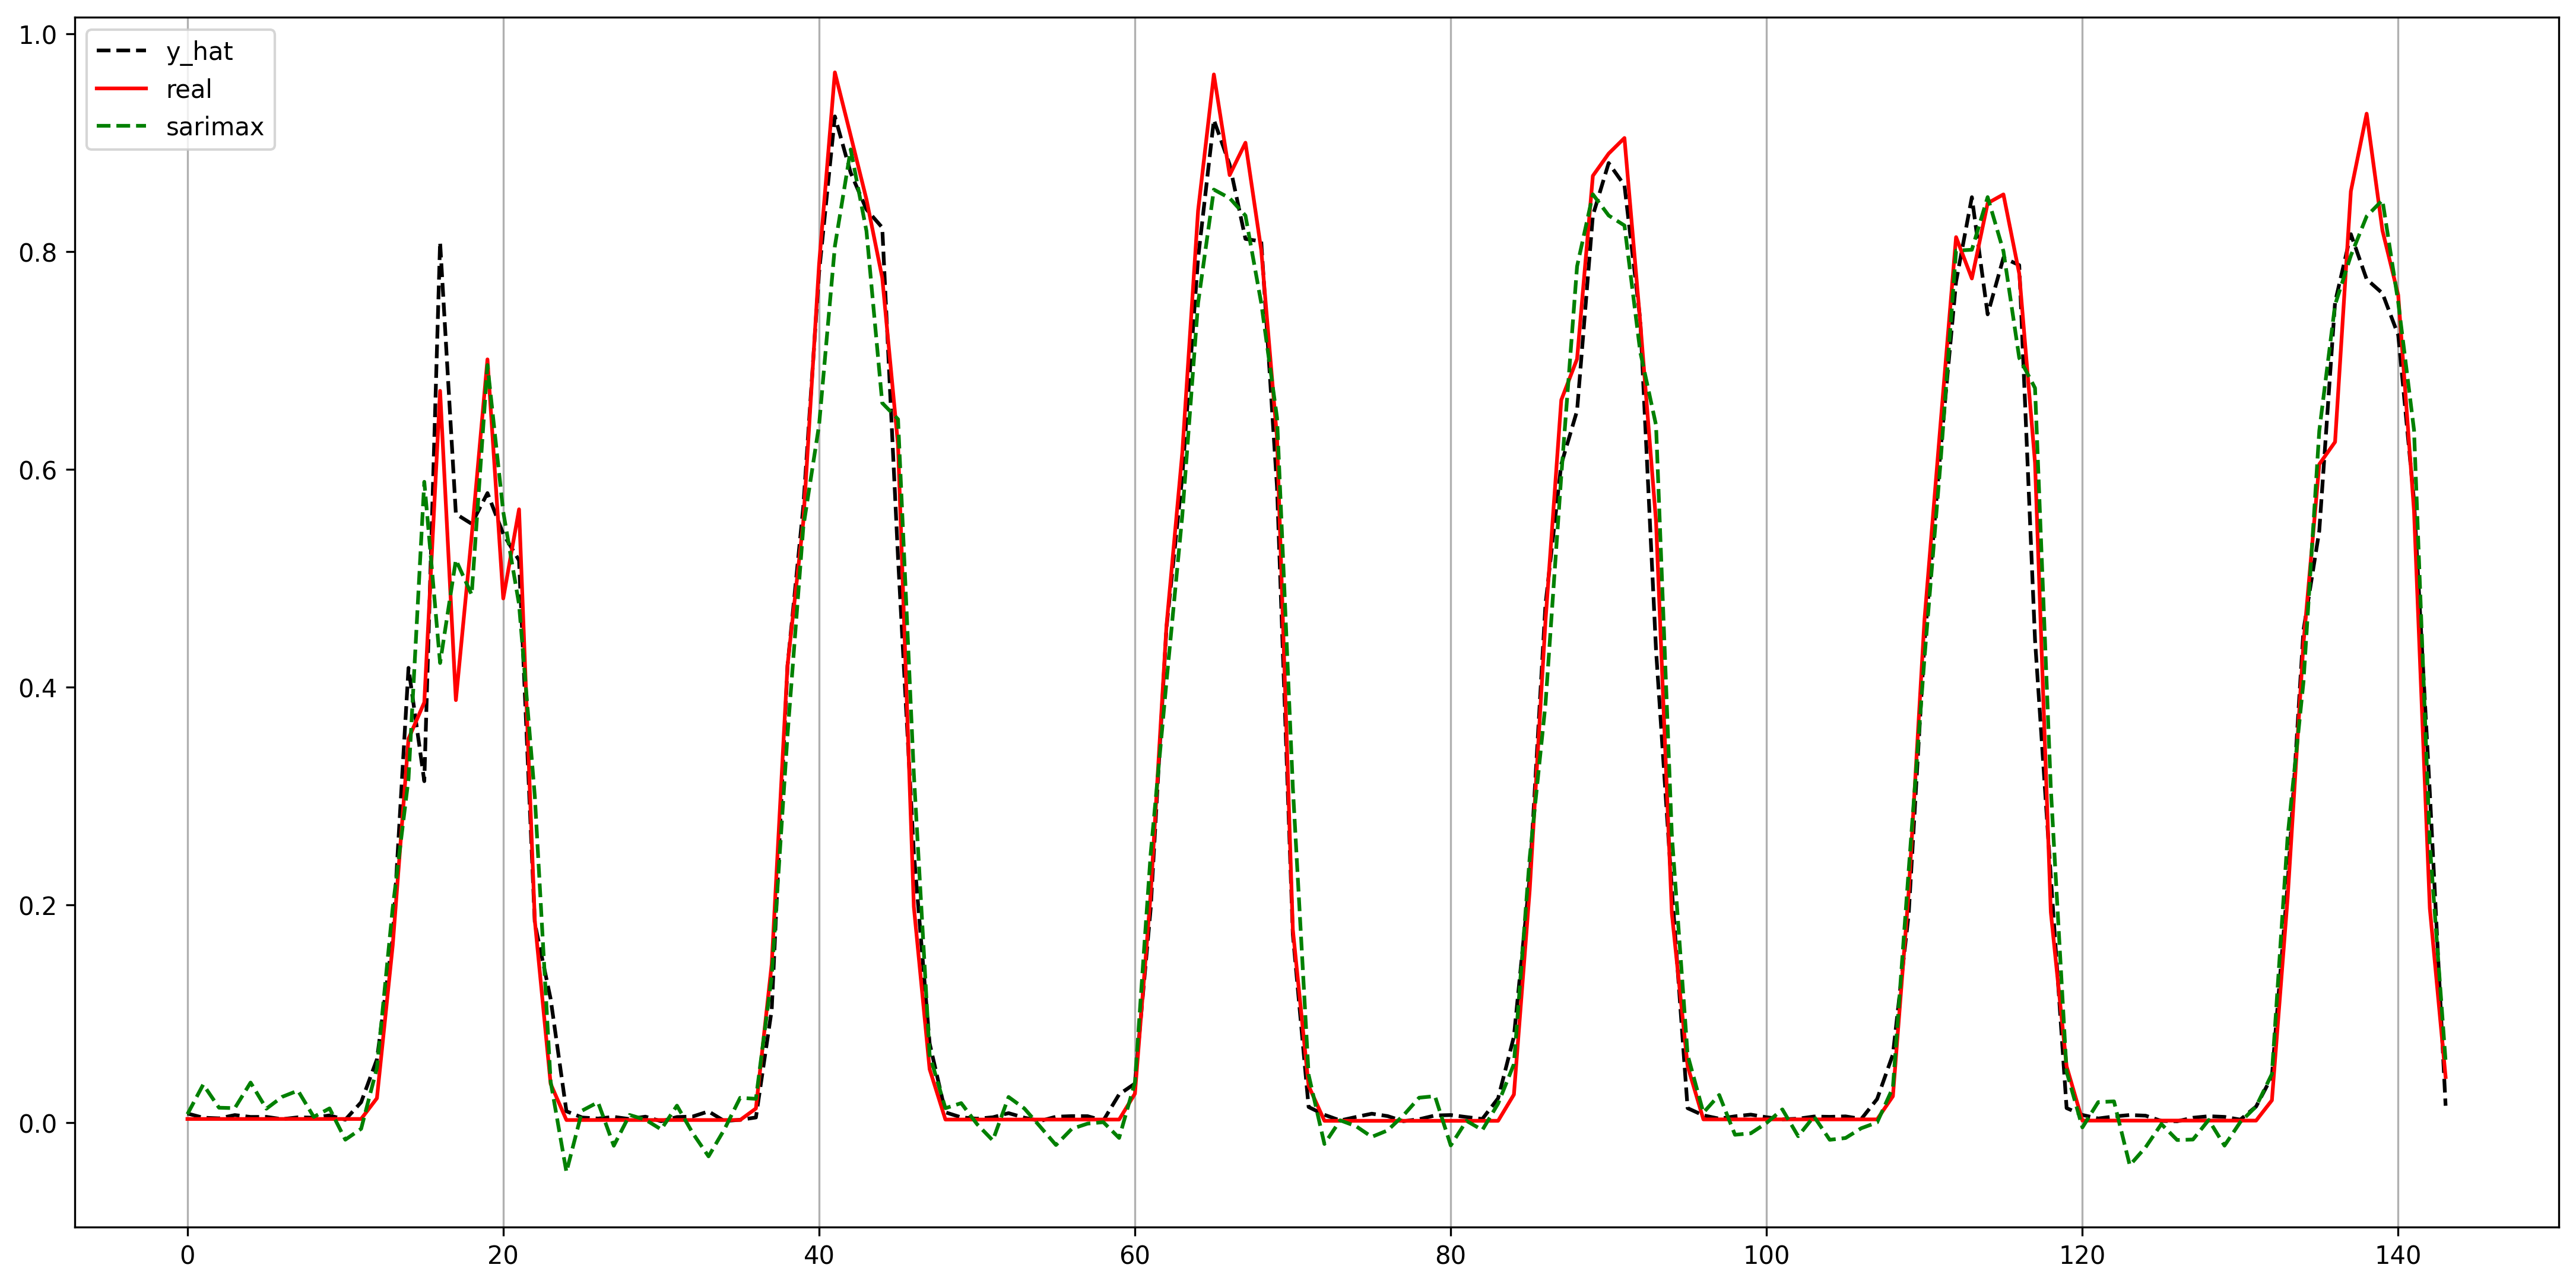

In [7]:
dict_series = pickle.load(open('resultados/dict_gen_ysarimax.pckl', 'rb'))
MaxAbsScaler_gen = pickle.load(open('resultados/MaxAbsScaler_gen.pckl', 'rb'))
best = pickle.load(open('resultados/best_model_AGMLP_RESIDUAL.pckl', 'rb'))

tr_ts_percents=[80,20]

gen = dict_series['generation']
y_sarimax = dict_series['y_sarimax']

erro = gen - y_sarimax

data_train = gen[0:int(len(y_sarimax)*tr_ts_percents[0]/100)]
data_test = gen[int(len(y_sarimax)*tr_ts_percents[0]/100):]

erro_train_entrada, erro_train_saida, erro_test_entrada, erro_test_saida = train_test_split(erro, best[0], tr_ts_percents)
erro_estimado = np.concatenate((best[4].predict(erro_train_entrada), best[4].predict(erro_test_entrada)))

X_ass_1_train_in, _, X_ass_1_test_in, _ = train_test_split(y_sarimax, best[1], tr_ts_percents)
X_ass_2_train_in, _, X_ass_2_test_in, _ = train_test_split_prev(erro_estimado, best[2], best[3], tr_ts_percents)

X_in_train = np.concatenate((X_ass_1_train_in, X_ass_2_train_in), axis=1)
X_in_test = np.concatenate((X_ass_1_test_in, X_ass_2_test_in), axis=1) 

y_estimado_all = np.concatenate([best[5].predict(X_in_train), best[5].predict(X_in_test)])
y_estimado_all_residual = y_estimado_all
y_estimado_so_test = best[5].predict(X_in_test)

len_dt = len(data_test)

print(best)
print("Teste para saber se pegou o melhor mesmo! {} == {} ?".format(mae(y_estimado_so_test, data_test),best[6]))
print (mae(y_estimado_so_test, data_test) ==  best[6])

print('Resultado Dados Teste!')
print('SARIMAX')
print('MAE: ', mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('HIBRIDO')
print('MAE: ', mae(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))

print ('GANHO MAE:')
print (1-mae(y_estimado_so_test, data_test[-len_dt:])/mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MSE:')
print (1-mse(y_estimado_so_test, data_test[-len_dt:])/mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MAPE:')
print (1-MAPE(y_estimado_so_test, data_test[-len_dt:])/MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))

plt.figure(figsize=(18,9), dpi=300)
plt.plot(y_estimado_all[-len_dt:], 'k--', label='y_hat')
plt.plot(gen[-len_dt:], 'r', label='real')
plt.plot(y_sarimax[-len_dt:], 'g--', label='sarimax')
plt.grid(axis='x')
plt.legend()

In [39]:
fig, ax = plt.subplots(1,1, figsize=(14,7), dpi=300)

ticks_X = df_inmet.data.astype('str') + '-' + df_inmet.hora.astype('str')
ticks_X = ticks_X[-len_dt:]
loc = plticker.MultipleLocator(base=3.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado_all[-len_dt:].reshape(-1, 1)), 'k-->', label='HIBRIDO')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(gen[-len_dt:].reshape(-1, 1)), 'r--*', label='REAL')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_sarimax[-len_dt:].reshape(-1, 1)), 'g--+', label='SARIMAX')
plt.xticks(ticks_X[::3], rotation=45, ha='right', fontsize=12)
ax.grid(axis='x')
    
ax.legend(fontsize=14)
ax.set_ylabel('W/m2', fontsize=14)
plt.tight_layout()
plt.savefig('resultados/maceio_agmlpresidual_epoch3_pop12.png', dpi=300)

## 1 day ahead forecast

In [112]:
# aqui é um exemplo de como fazer 1 day ahead forecast com base no algoritmo
# esse exemplo é importante pq da para ver que tem como implementar. Porém 1 day ahead é muita coisa, visto
# que são usados dados horários, então obiviamente o resultado não é bom.

erro = gen - y_sarimax

gen_day_ahead = gen.copy()
y_sarimax_day_ahead = y_sarimax.copy()

for i in range(24):
    
    erro_day_ahead = gen_day_ahead - y_sarimax_day_ahead
    
    data_train = gen_day_ahead[0:int(len(y_sarimax_day_ahead)*tr_ts_percents[0]/100)]
    data_test = gen_day_ahead[int(len(y_sarimax_day_ahead)*tr_ts_percents[0]/100):]

    erro_estimado_for_forecast = best[4].predict(erro_day_ahead[-best[0]:].reshape(1,-1))

    erro_fut = erro_day_ahead.copy()
    for _ in range(best[3]):
        erro_fut = np.append(erro_day_ahead, best[4].predict(erro_fut[-best[0]:].reshape(1,-1)))

    X_ass_1_forecast_in = y_sarimax_day_ahead[-best[1]-1:]
    X_ass_2_forecast_in = np.concatenate((erro_estimado_for_forecast[-best[2]-1:], erro_fut[-best[3]-1:]))

    X_in_forecast = np.concatenate((X_ass_1_forecast_in, X_ass_2_forecast_in))

    y_forecast = best[5].predict(X_in_forecast.reshape(1,-1))

    gen_day_ahead = np.append(gen_day_ahead, y_forecast)
    y_sarimax_day_ahead = np.append(y_sarimax_day_ahead, y_sarimax_ahead[i])
    
plt.plot(MaxAbsScaler_gen.inverse_transform(gen_day_ahead[-24:].reshape(-1,1)))

# Algoritmo AGMLP_VR_Residual

In [113]:
tr_ts_percents=[80,20]

## Train

In [26]:
# ag_mlp_vr_residual = AGMLP_VR_Residual(gen, y_sarimax, num_epochs = 3, size_pop = 12,
#                                        prob_mut=0.2, tr_ts_percents=tr_ts_percents).search_best_model()

# best_mlp_vr_residual = ag_mlp_vr_residual._best_of_all

# pickle.dump(best_mlp_vr_residual, open('resultados/best_model_AGMLP_VR_RESIDUAL.pckl', 'wb'))

start_set_fit: 0
  0%|          | 0/3 [00:00<?, ?it/s]generation: 0
start_set_fit: 0

100%|██████████| 3/3 [00:17<00:00,  5.90s/it]

100%|██████████| 3/3 [00:53<00:00, 17.69s/it]

100%|██████████| 3/3 [00:11<00:00,  3.90s/it]

100%|██████████| 3/3 [00:28<00:00,  9.37s/it]

100%|██████████| 3/3 [00:11<00:00,  3.84s/it]

100%|██████████| 3/3 [00:43<00:00, 14.42s/it]

100%|██████████| 3/3 [00:20<00:00,  6.99s/it]

100%|██████████| 3/3 [00:32<00:00, 10.83s/it]

100%|██████████| 3/3 [00:15<00:00,  5.25s/it]

100%|██████████| 3/3 [00:41<00:00, 13.72s/it]

100%|██████████| 3/3 [00:15<00:00,  5.08s/it]

100%|██████████| 3/3 [00:32<00:00, 10.71s/it]

100%|██████████| 3/3 [00:07<00:00,  2.60s/it]

100%|██████████| 3/3 [00:42<00:00, 14.27s/it]

100%|██████████| 3/3 [00:20<00:00,  6.97s/it]

100%|██████████| 3/3 [00:17<00:00,  5.90s/it]

100%|██████████| 3/3 [00:13<00:00,  4.55s/it]

100%|██████████| 3/3 [00:27<00:00,  9.16s/it]

100%|██████████| 3/3 [00:30<00:00, 10.29s/it]

100%|██████████| 3/3 

## Results

[16, 16, 4, 16, 20, <mlopt.AgMlp.AgMlp object at 0x0000018B9C3E0310>, <mlopt.AgMlp.AgMlp object at 0x0000018B9C3B0070>, 0.026848473486150163]
Teste para saber se pegou o melhor mesmo! 0.026848473486150163 == <mlopt.AgMlp.AgMlp object at 0x0000018B9C3B0070> ?
False
Resultado Dados Teste!
SARIMAX
MAE:  0.035221778465560835
MSE:  0.0029411509830490398
MAPE:  2.9130356221922984
HIBRIDO
MAE:  0.026848473486150163
MSE:  0.0024394409996036323
MAPE:  0.5304537873955746
GANHO MAE:
0.23773089674043368
GANHO MSE:
0.17058287260224003
GANHO MAPE:
0.8179034326410453


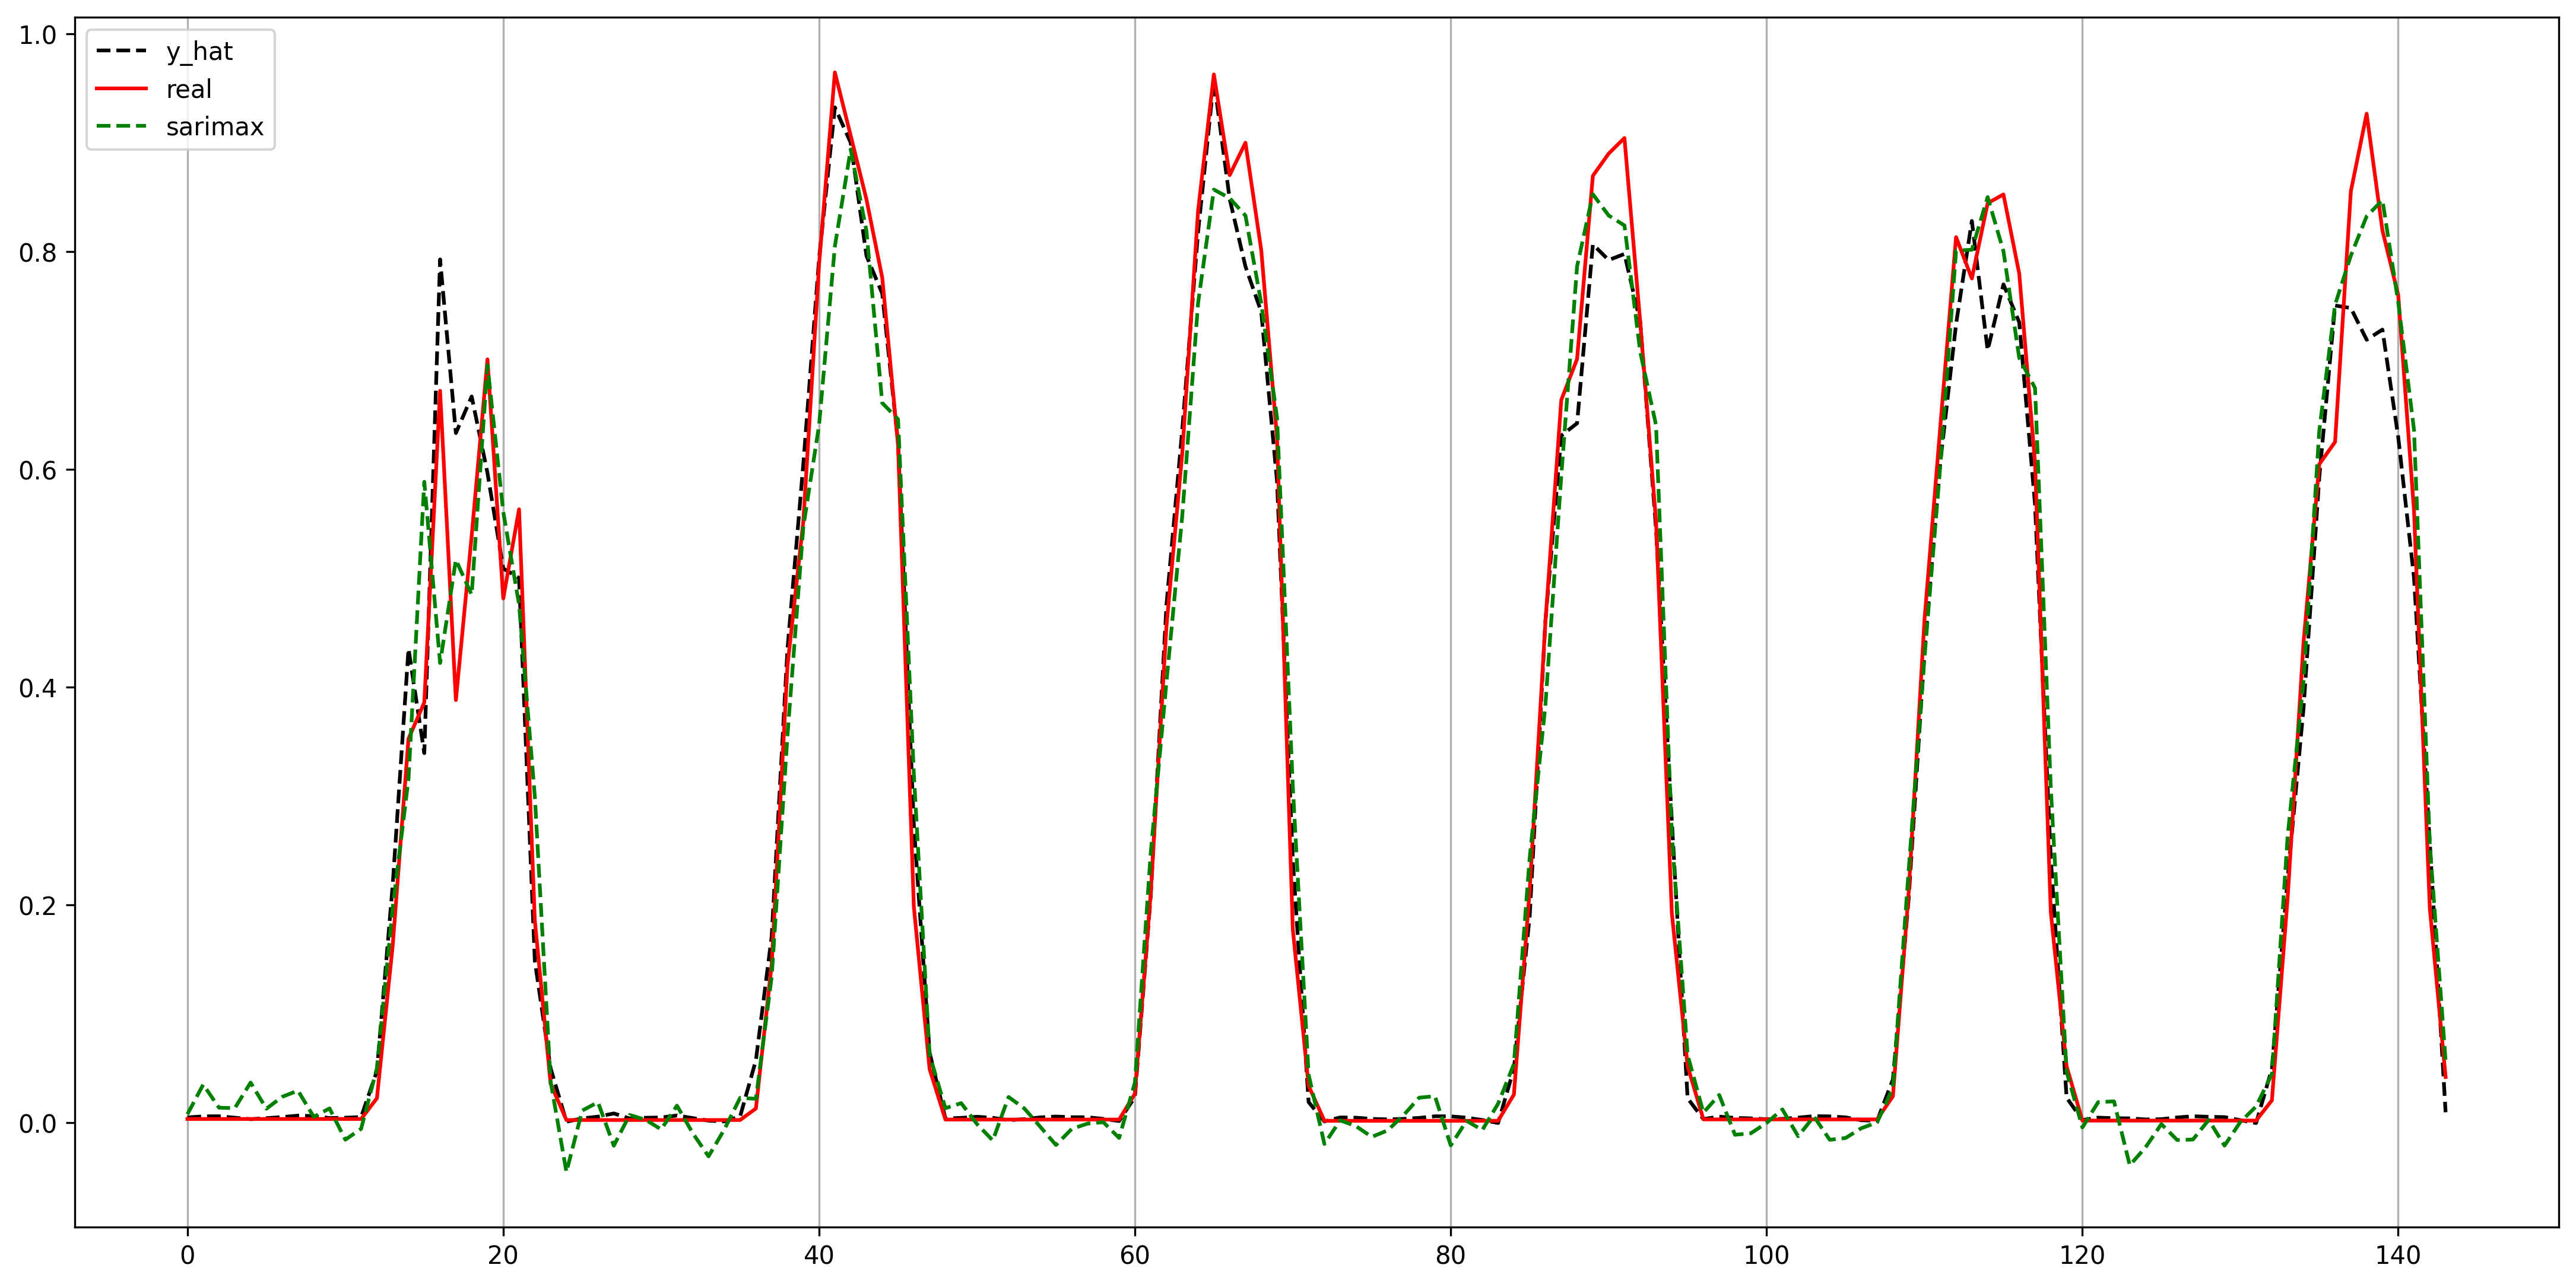

In [8]:
tr_ts_percents=[80,20]

dict_series = pickle.load(open('resultados/dict_gen_ysarimax.pckl', 'rb'))
MaxAbsScaler_gen = pickle.load(open('resultados/MaxAbsScaler_gen.pckl', 'rb'))

tr_ts_percents=[80,20]

gen = dict_series['generation']
y_sarimax = dict_series['y_sarimax']

best = pickle.load(open('resultados/best_model_AGMLP_VR_RESIDUAL.pckl', 'rb'))

erro = gen - y_sarimax

data_train = gen[0:int(len(y_sarimax)*tr_ts_percents[0]/100)]
data_test = gen[int(len(y_sarimax)*tr_ts_percents[0]/100):]

erro_train_entrada, erro_train_saida, erro_test_entrada, erro_test_saida = train_test_split(erro, best[0], tr_ts_percents)
erro_estimado = np.concatenate((best[-3].VR_predict(erro_train_entrada), best[-3].VR_predict(erro_test_entrada)))

X_ass_1_train_in, _, X_ass_1_test_in, _ = train_test_split(y_sarimax, best[1], tr_ts_percents)
X_ass_2_train_in, _, X_ass_2_test_in, _ = train_test_split_prev(erro_estimado, best[2], best[3], tr_ts_percents)

X_in_train = np.concatenate((X_ass_1_train_in, X_ass_2_train_in), axis=1)
X_in_test = np.concatenate((X_ass_1_test_in, X_ass_2_test_in), axis=1) 

y_estimado_all = np.concatenate([best[-2].VR_predict(X_in_train), best[-2].VR_predict(X_in_test)])
y_estimado_all_vr_residual = y_estimado_all
y_estimado_so_test = best[-2].VR_predict(X_in_test)

len_dt = len(data_test)

print(best)
print("Teste para saber se pegou o melhor mesmo! {} == {} ?".format(mae(y_estimado_so_test, data_test),best[6]))
print (mae(y_estimado_so_test, data_test) ==  best[6])

print('Resultado Dados Teste!')
print('SARIMAX')
print('MAE: ', mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('HIBRIDO')
print('MAE: ', mae(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))

print ('GANHO MAE:')
print (1-mae(y_estimado_so_test, data_test[-len_dt:])/mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MSE:')
print (1-mse(y_estimado_so_test, data_test[-len_dt:])/mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MAPE:')
print (1-MAPE(y_estimado_so_test, data_test[-len_dt:])/MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))

plt.figure(figsize=(18,9), dpi=300)
plt.plot(y_estimado_all[-len_dt:], 'k--', label='y_hat')
plt.plot(gen[-len_dt:], 'r', label='real')
plt.plot(y_sarimax[-len_dt:], 'g--', label='sarimax')
plt.grid(axis='x')
plt.legend()

In [45]:
fig, ax = plt.subplots(1,1, figsize=(14,7), dpi=300)

ticks_X = df_inmet.data.astype('str') + '-' + df_inmet.hora.astype('str')
ticks_X = ticks_X[-len_dt:]
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado_all[-len_dt:].reshape(-1, 1)), 'k-->', label='HIBRIDO')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(gen[-len_dt:].reshape(-1, 1)), 'r--*', label='REAL')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_sarimax[-len_dt:].reshape(-1, 1)), 'g--+', label='ARIMA')
plt.xticks(ticks_X[::3], rotation=45, ha='right', fontsize=12)
ax.grid(axis='x')
    
ax.legend(fontsize=12)
ax.set_ylabel('W/m2', fontsize=12)
plt.tight_layout()
plt.savefig('resultados/maceio_agmlpvrresidual_epoch3_pop12.png', dpi=300)

# LSTM + MLP

Without exogenous variables

https://www.sciencedirect.com/science/article/abs/pii/S0360544218302056

https://www.sciencedirect.com/science/article/abs/pii/S0960148120308557

## Train

In [44]:
from mlopt.ACOLSTM import ACOLSTM
# Importing only here becouse TF takes too long to import

options_ACO={'antNumber':2, 'antTours':1, 'alpha':1, 'beta':1, 'rho':0.5, 'Q':1}
fl_qtn = [10, 30, 70, 100]
fl_func = list(range(6))             
sl_qtn = [5, 10, 20, 40]
sl_func = list(range(6))
tl_qtn = [1, 10, 15]
tl_func = list(range(6))
optimizer = list(range(4))
epochs = list(range(3))
searchSpace = [fl_qtn, fl_func, sl_qtn, sl_func, tl_qtn, tl_func, optimizer, epochs]
X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm = train_test_split(gen, 23,
                                                                        tr_vd_ts_percents = [80, 20],
                                                                        print_shapes = True)

X_train:  (576, 23)
y_train:  (576, 1)
X_test:  (144, 23)
y_test:  (144, 1)


In [32]:
lstmOptimizer = ACOLSTM(X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm, 1,
                        options_ACO=options_ACO)

final_model, y_hat = lstmOptimizer.optimize(searchSpace)

100%|██████████| 1/1 [04:55<00:00, 295.29s/it]


ACO-All Best Response: [70  2 40  5 15  1  2  2]. Fitness: 0.03255305817764589


In [35]:
final_model.save('./resultados/lstm_model')

INFO:tensorflow:Assets written to: ./resultados/lstm_model\assets


2021-03-27 19:39:08,507 - tensorflow - INFO - Assets written to: ./resultados/lstm_model\assets
2021-03-27 19:39:08,507: INFO - Assets written to: ./resultados/lstm_model\assets


## Results

In [10]:
from tensorflow import keras

_, _, X_test_lstm, y_test_lstm = train_test_split(gen, 23,tr_vd_ts_percents = [80, 20],print_shapes = True)
loadedmodel = keras.models.load_model('./resultados/lstm_model')
y_hat_lstm = loadedmodel.predict(X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1)))

print('Resultado Dados Teste!')
print('LSTM')
print('MAE: ', mae(y_hat_lstm, y_test_lstm))
print('MSE: ', mse(y_hat_lstm, y_test_lstm))
print('MAPE: ', MAPE(y_hat_lstm, y_test_lstm))

X_train:  (576, 23)
y_train:  (576, 1)
X_test:  (144, 23)
y_test:  (144, 1)


2021-04-12 23:51:20,905 - tensorflow - WARNING - Layer lstm_110 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-04-12 23:51:20,905: WARNING - Layer lstm_110 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-04-12 23:51:22,077 - tensorflow - WARNING - Layer lstm_111 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-04-12 23:51:22,077: WARNING - Layer lstm_111 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


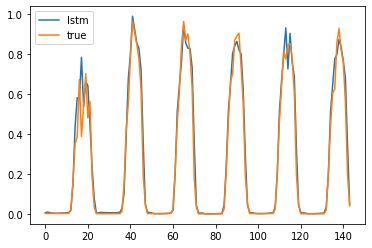

In [49]:
plt.plot(y_hat_lstm, label='lstm')
plt.plot(y_test_lstm, label='true')
plt.legend()

# Figura Unica

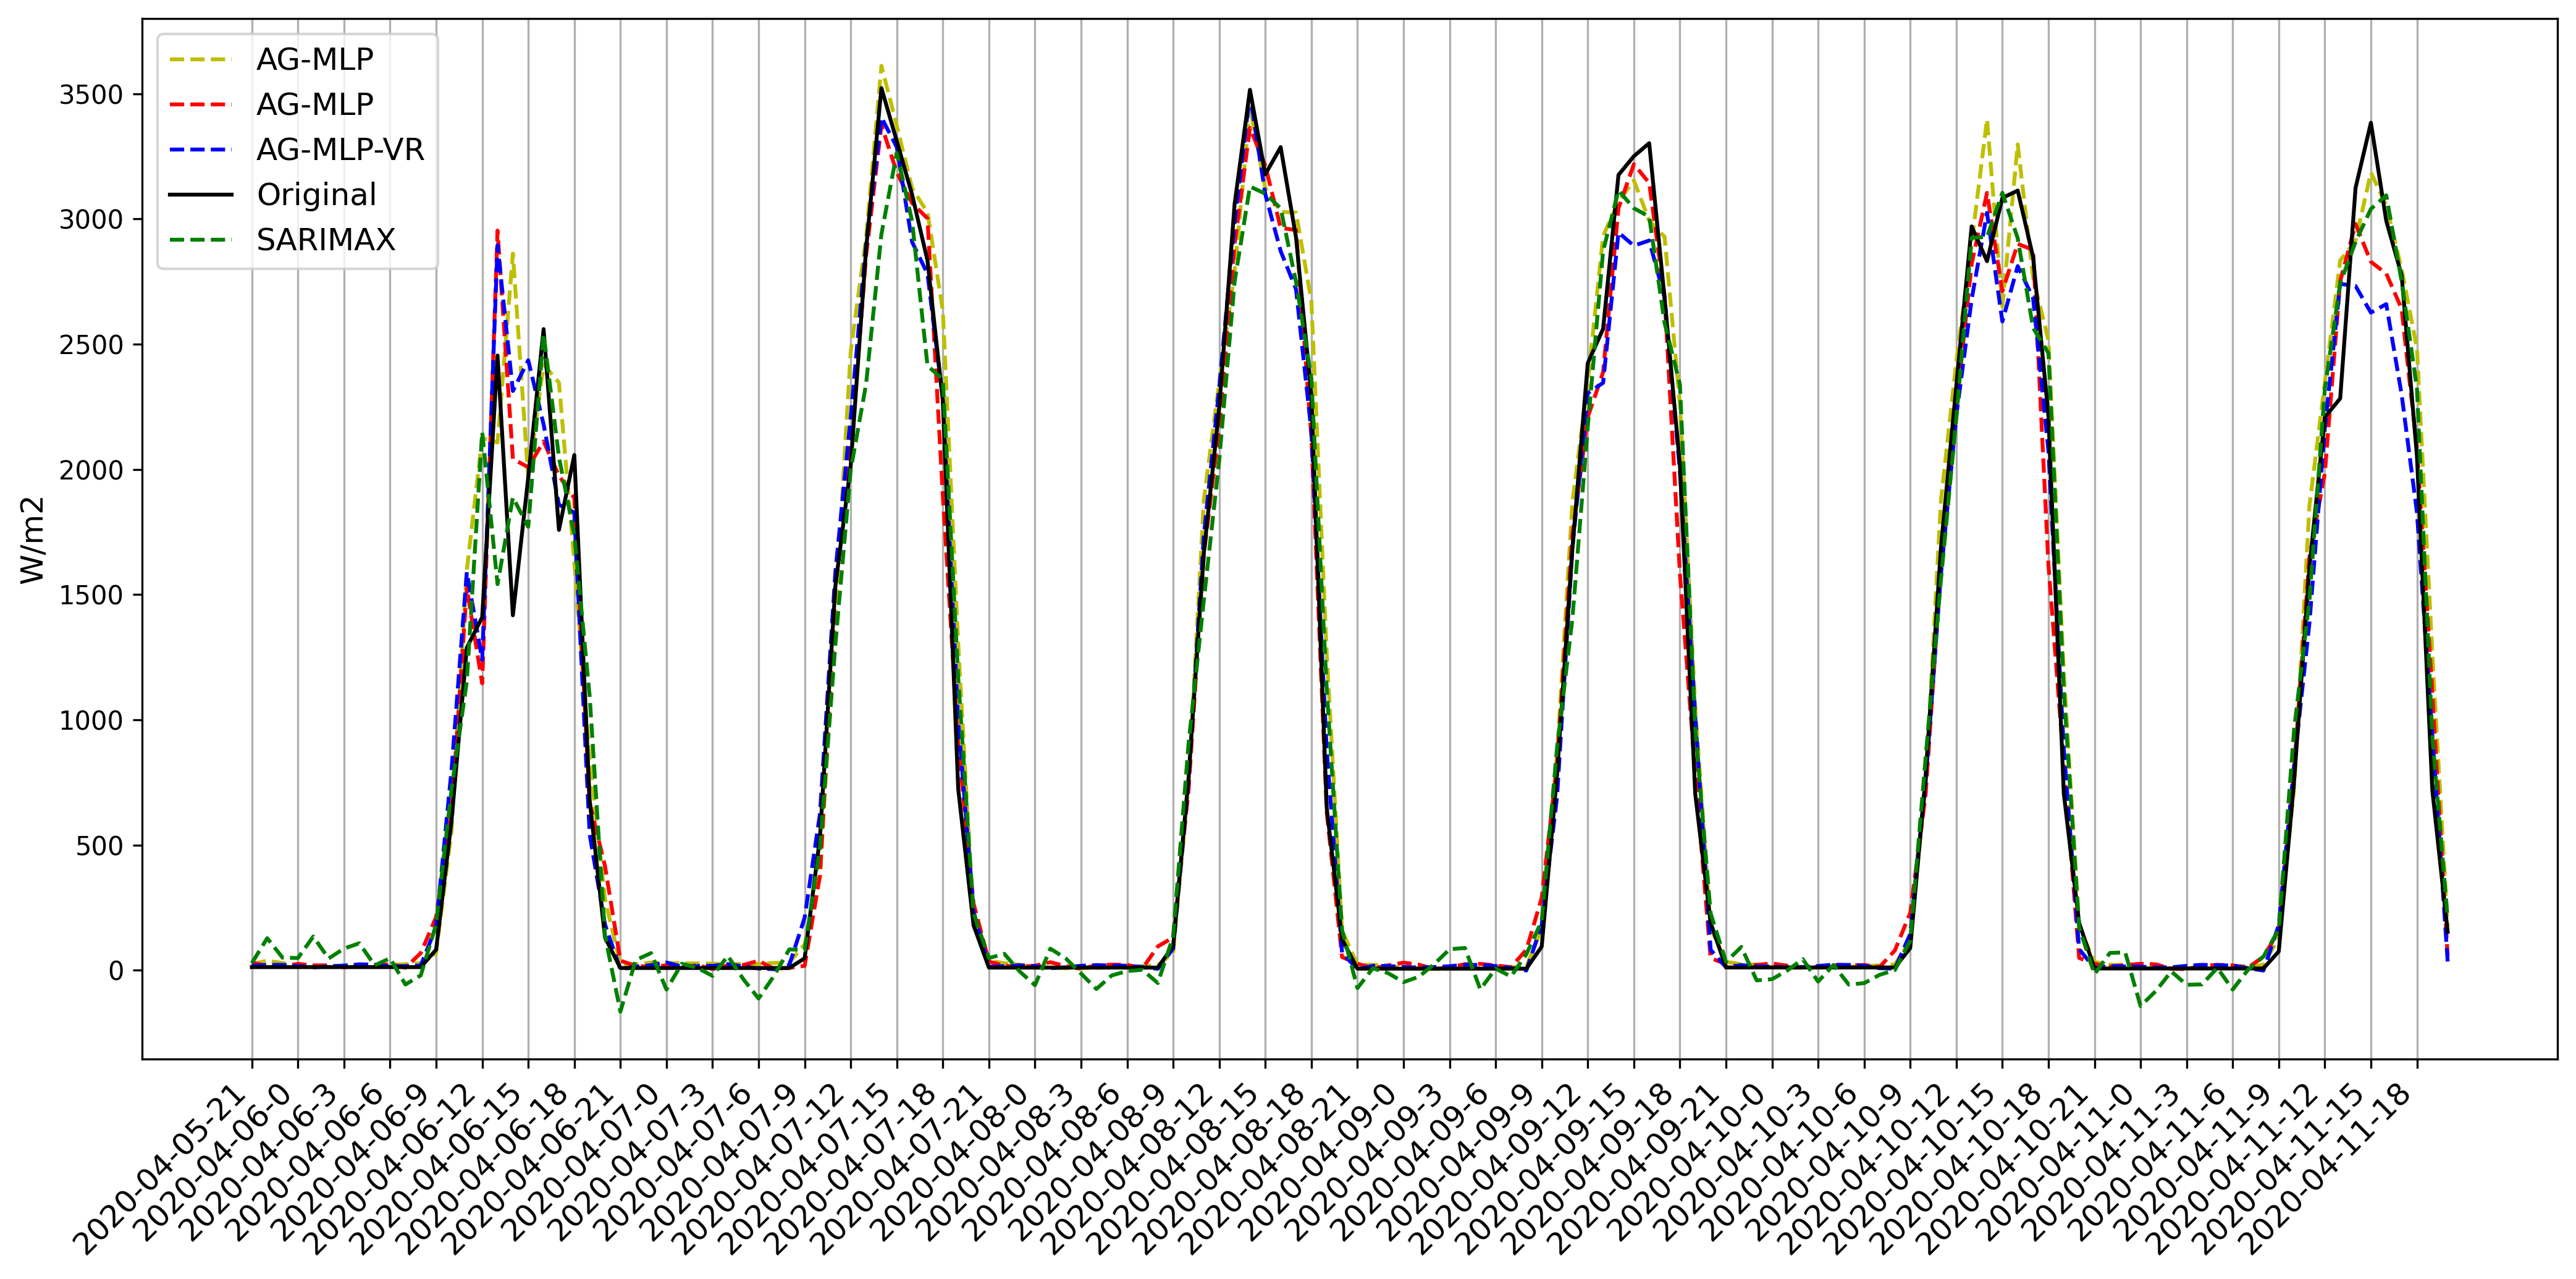

In [15]:
fig, ax = plt.subplots(1,1, figsize=(14,7), dpi=300)

ticks_X = df_inmet.data.astype('str') + '-' + df_inmet.hora.astype('str')
ticks_X = ticks_X[-len_dt:]
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_hat_lstm[-len_dt:].reshape(-1, 1)), 'y--', label='AG-MLP')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado_all_residual[-len_dt:].reshape(-1, 1)), 'r--', label='AG-MLP')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado_all_vr_residual[-len_dt:].reshape(-1, 1)), 'b--', label='AG-MLP-VR')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(gen[-len_dt:].reshape(-1, 1)), 'k', label='Original')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_sarimax[-len_dt:].reshape(-1, 1)), 'g--', label='SARIMAX')
plt.xticks(ticks_X[::3], rotation=45, ha='right', fontsize=12)
ax.grid(axis='x')
    
ax.legend(fontsize=12)
ax.set_ylabel('W/m2', fontsize=12)
plt.tight_layout()
plt.savefig('resultados/comparison_hibrids.png', dpi=300)

# Depois

## Algoritmo AGEmsemble_Residual

### Train

In [ ]:
agensemble_residual = AGEnsemble_Residual(gen, y_sarimax, num_epochs = 7, size_pop = 5, 
                                          prob_mut=0.8, tr_ts_percents=[80,20]).search_best_model()

best_agensemble_residual = agensemble_residual._best_of_all

pickle.dump(best_agensemble_residual, open('resultados/best_model_AGEmsemble_RESIDUAL.pckl', 'wb'))

### Results

In [ ]:
dict_series = pickle.load(open('resultados/dict_gen_ysarimax.pckl', 'rb'))
MaxAbsScaler_gen = pickle.load(open('resultados/MaxAbsScaler_gen.pckl', 'rb'))

gen = dict_series['generation']
y_sarimax = dict_series['y_sarimax']

best = pickle.load(open('resultados/best_model_AGEmsemble_RESIDUAL.pckl', 'rb'))

erro = gen - y_sarimax

threshold = int(len(y_sarimax)*0.8)

data_train = gen[0:threshold]
data_test = gen[threshold:]

erro_train_entrada, erro_train_saida, erro_test_entrada, erro_test_saida = train_test_split(erro, best[0], [80, 20])
erro_estimado = np.concatenate((best[4].predict(erro_train_entrada), best[4].predict(erro_test_entrada)))

X_ass_1_train_in, _, X_ass_1_test_in, _ = train_test_split(y_sarimax, best[1], [80, 20])
X_ass_2_train_in, _, X_ass_2_test_in, _ = train_test_split_prev(erro_estimado, best[2], best[3], [80, 20])

X_in_train = np.concatenate((X_ass_1_train_in, X_ass_2_train_in), axis=1)
X_in_test = np.concatenate((X_ass_1_test_in, X_ass_2_test_in), axis=1) 

y_estimado_all = np.concatenate([best[5].predict(X_in_train), best[5].predict(X_in_test)])
y_estimado_so_test = best[5].predict(X_in_test)

len_dt = len(data_test)

print(best)
print("Teste para saber se pegou o melhor mesmo! {} == {} ?".format(mae(y_estimado_so_test, data_test),best[6]))
print (mae(y_estimado_so_test, data_test) ==  best[6])

print('Resultado Dados Teste!')
print('SARIMAX')
print('MAE: ', mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('HIBRIDO')
print('MAE: ', mae(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))

print ('GANHO MAE:')
print (1-mae(y_estimado_so_test, data_test[-len_dt:])/mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MSE:')
print (1-mse(y_estimado_so_test, data_test[-len_dt:])/mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MAPE:')
print (1-MAPE(y_estimado_so_test, data_test[-len_dt:])/MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))

plt.figure(figsize=(18,9), dpi=300)
plt.plot(y_estimado_all[-len_dt:], 'k--', label='y_hat')
plt.plot(gen[-len_dt:], 'r', label='real')
plt.plot(y_sarimax[-len_dt:], 'g--', label='sarimax')
plt.grid(axis='x')
plt.legend()

## SARIMAX + LSTM

### Train

In [65]:
from mlopt.LSTM_Residual import LSTM_Residual

options_ACO={'antNumber':4, 'antTours':3, 'alpha':1, 'beta':1, 'rho':0.5, 'Q':1}
fl_qtn = [10, 30, 70, 100]
fl_func = list(range(6))             
sl_qtn = [5, 10, 20, 40]
sl_func = list(range(6))
tl_qtn = [1, 10, 15]
tl_func = list(range(6))
optimizer = list(range(4))
epochs = list(range(3))
searchSpace = [fl_qtn, fl_func, sl_qtn, sl_func, tl_qtn, tl_func, optimizer, epochs]

LSTM_Residual_Obj = LSTM_Residual(gen, y_sarimax)

In [66]:
final_mode, y_hat_test_sarimax_lstm = LSTM_Residual_Obj.fit(24, searchSpace, options_ACO, saturate=False)

  0%|          | 0/3 [00:00<?, ?it/s]2021-04-11 23:30:38,510 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-04-11 23:30:38,510: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-04-11 23:30:38,510: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-04-11 23:30:38,510: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-04-11 23:30:40,063 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-04-11 23

2021-04-12 00:46:20,288 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-04-12 00:46:20,288: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-04-12 00:46:20,288: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-04-12 00:46:20,288: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-04-12 00:59:13,409 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-04-12 00:59:13,409: WARNING - Layer lst

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [67]:
final_mode.save('./resultados/sarimax_lstm_model')

2021-04-12 22:52:44,475 - tensorflow - INFO - Assets written to: ./resultados/sarimax_lstm_model\assets
2021-04-12 22:52:44,475: INFO - Assets written to: ./resultados/sarimax_lstm_model\assets
2021-04-12 22:52:44,475: INFO - Assets written to: ./resultados/sarimax_lstm_model\assets
2021-04-12 22:52:44,475: INFO - Assets written to: ./resultados/sarimax_lstm_model\assets


In [78]:
error = gen - y_sarimax
erro_train_entrada, erro_train_saida, erro_test_entrada, erro_test_saida = train_test_split(error, 24)
erro_test_entrada = erro_test_entrada.reshape(erro_test_entrada.shape[0],erro_test_entrada.shape[1],1)
predicted_error_manual = final_mode.predict(erro_test_entrada)

In [83]:
plt.plot(predicted_error_manual, label="predicted erro")
plt.plot(error[-erro_test_entrada.shape[0]:], label="true error")
plt.legend()

### Results

In [68]:
_, _, _, y_test = train_test_split(gen, 24,tr_vd_ts_percents = [80, 20],print_shapes = True)

X_train:  (576, 24)
y_train:  (576, 1)
X_test:  (144, 24)
y_test:  (144, 1)


In [69]:
print('Resultado Dados Teste!')
print('LSTM')
print('MAE: ', mae( y_hat_test_sarimax_lstm, y_test))
print('MSE: ', mse(y_hat_test_sarimax_lstm, y_test))
print('MAPE: ', MAPE(y_hat_test_sarimax_lstm, y_test[:,0]))

Resultado Dados Teste!
LSTM
MAE:  0.03545605908742798
MSE:  0.0029621376284869414
MAPE:  3.025380829820234


In [70]:
plt.plot(y_hat_test_sarimax_lstm, label='hat')
plt.plot(y_test, label='true')
plt.legend()